In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
train = zipfile.ZipFile("/content/drive/MyDrive/AI突擊!/crop_224_train.zip")
train.extractall("datas")
train = zipfile.ZipFile("/content/drive/MyDrive/AI突擊!/original_resize_train.zip")
train.extractall("datas")
predict = zipfile.ZipFile("/content/drive/MyDrive/AI突擊!/original_resize_predict.zip")
predict.extractall("datas")

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imgaug as ia
import imgaug.augmenters as iaa
from random import shuffle

In [ ]:
import os
train_dir = 'datas/cropped_original_resize/'
classes = os.listdir(train_dir)
classes.sort()
d = {folder:idx for idx, folder in enumerate(classes)}
d

{'asparagus': 0,
 'bambooshoots': 1,
 'betel': 2,
 'broccoli': 3,
 'cauliflower': 4,
 'chinesecabbage': 5,
 'chinesechives': 6,
 'custardapple': 7,
 'grape': 8,
 'greenhouse': 9,
 'greenonion': 10,
 'kale': 11,
 'lemon': 12,
 'lettuce': 13,
 'litchi': 14,
 'longan': 15,
 'loofah': 16,
 'mango': 17,
 'onion': 18,
 'others': 19,
 'papaya': 20,
 'passionfruit': 21,
 'pear': 22,
 'pennisetum': 23,
 'redbeans': 24,
 'roseapple': 25,
 'sesbania': 26,
 'soybeans': 27,
 'sunhemp': 28,
 'sweetpotato': 29,
 'taro': 30,
 'tea': 31,
 'waterbamboo': 32}

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df1 = pd.read_csv('/content/drive/MyDrive/AI突擊!/files/tag_locCoor_utf8_with_elevation.csv')
df2 = pd.read_csv('/content/drive/MyDrive/AI突擊!/files/tag_loccoor_public_utf8_with_elevation.csv')
columns = ['Img', 'town_x', 'town_y', 'elevation', 'COUNTYNAME', 'TOWNNAME']
df_all = pd.concat([df1[columns], df2[columns]])
scaler = MinMaxScaler()
df_all[['town_x', 'town_y', 'elevation']] = scaler.fit_transform(df_all[['town_x', 'town_y', 'elevation']])
df_county = pd.get_dummies(df_all['COUNTYNAME'])
df_town = pd.get_dummies(df_all['TOWNNAME'])
df_final = pd.concat([df_all, df_county, df_town], axis = 1)
df_final.drop(['COUNTYNAME', 'TOWNNAME'], axis=1, inplace=True)
df_final

,Img,town_x,town_y,elevation,南投縣,嘉義市,嘉義縣,宜蘭縣,屏東縣,彰化縣,...,鹽埔鄉,鹿港鎮,鹿草鄉,鹿谷鄉,鹿野鄉,麟洛鄉,麥寮鄉,麻豆區,龍井區,龍崎區
0,000b43a3-d331-47ad-99a4-4c0fa9b48298.jpg,0.183627,0.615257,0.009001,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,00172189-3156-48d7-bb1e-f0a922bc54b8.jpg,0.183627,0.615257,0.009001,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,002aec7b-648e-4d1f-9463-a43c0304e774.jpg,0.149950,0.493194,0.006429,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,007cd63a-333c-47f2-b2e2-193f76f7c684.jpg,0.159844,0.541076,0.007287,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00a326ba-7e9a-4bc1-8684-4bf404bfd6bb.jpg,0.230830,0.534342,0.017574,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11143,ffef051e-044c-4e30-9067-4d840a0252e6.jpg,0.251544,0.372267,0.070724,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11144,ffefbeee-d580-4aba-bdc8-eecd9cee4591.jpg,0.216049,0.570181,0.012430,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11145,ffefe03e-842c-44cb-a7c2-4649f42742c8.jpg,0.196382,0.218082,0.028718,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11146,fff5eae5-791c-4d2b-b501-868f443f90f1.jpg,0.083553,0.574095,0.003429,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
df_train = df_final[:len(df1)]
df_train

,Img,town_x,town_y,elevation,南投縣,嘉義市,嘉義縣,宜蘭縣,屏東縣,彰化縣,...,鹽埔鄉,鹿港鎮,鹿草鄉,鹿谷鄉,鹿野鄉,麟洛鄉,麥寮鄉,麻豆區,龍井區,龍崎區
0,000b43a3-d331-47ad-99a4-4c0fa9b48298.jpg,0.183627,0.615257,0.009001,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,00172189-3156-48d7-bb1e-f0a922bc54b8.jpg,0.183627,0.615257,0.009001,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,002aec7b-648e-4d1f-9463-a43c0304e774.jpg,0.149950,0.493194,0.006429,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,007cd63a-333c-47f2-b2e2-193f76f7c684.jpg,0.159844,0.541076,0.007287,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00a326ba-7e9a-4bc1-8684-4bf404bfd6bb.jpg,0.230830,0.534342,0.017574,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89509,ffb5fc02-3d23-47de-aced-eced1a44d005.jpg,0.537863,0.903323,0.037720,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89510,ffd7568f-fe75-4e57-85aa-c11ec9b88776.jpg,0.519766,0.635922,0.194171,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89511,ffd9c5f8-e928-4779-9f60-38549c127a48.jpg,0.519766,0.635922,0.194171,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89512,fff0cfff-825a-4684-afd3-f345aa1df056.jpg,0.519766,0.635922,0.194171,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_predict = df_final[len(df1):]
df_predict

,Img,town_x,town_y,elevation,南投縣,嘉義市,嘉義縣,宜蘭縣,屏東縣,彰化縣,...,鹽埔鄉,鹿港鎮,鹿草鄉,鹿谷鄉,鹿野鄉,麟洛鄉,麥寮鄉,麻豆區,龍井區,龍崎區
0,000bbbfa-15f7-43ba-b99e-0aacada1c782.jpg,0.216049,0.570181,0.012430,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,002b60b8-552b-4858-9a6a-e8c1eae8158e.jpg,0.231165,0.626956,0.010716,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,003fec26-e65c-49e1-97af-bf82bd76c2a0.jpg,0.243759,0.653578,0.007287,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,005adee4-d37e-4005-a106-2ec68ad21430.jpg,0.297333,0.628538,0.014145,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,005f8afc-679b-4303-88d6-562d6872dc1a.jpg,0.207662,0.405044,0.049293,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11143,ffef051e-044c-4e30-9067-4d840a0252e6.jpg,0.251544,0.372267,0.070724,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11144,ffefbeee-d580-4aba-bdc8-eecd9cee4591.jpg,0.216049,0.570181,0.012430,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11145,ffefe03e-842c-44cb-a7c2-4649f42742c8.jpg,0.196382,0.218082,0.028718,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11146,fff5eae5-791c-4d2b-b501-868f443f90f1.jpg,0.083553,0.574095,0.003429,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, batch_size, img_size, df, mode='train'):
        self.img_paths = img_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.df = df
        self.mode = mode
        self.aug = iaa.Sequential([iaa.Rot90([1, 3])])
        self.indexes = np.arange(len(self.img_paths)) # [0, 1, 2, ~]
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, batch_index):
        # Generate indexes of the batch
        idxs = self.indexes[batch_index * self.batch_size: (batch_index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        # Generates data containing batch_size samples
        x_norm = np.empty((len(batch_img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y_ori = np.empty((len(batch_img_paths), 1), dtype=np.float32)
        df_img = pd.DataFrame() 
        for i, img_path in enumerate(batch_img_paths):
            img = np.array(load_img(img_path, target_size=(self.img_size, self.img_size)))
            
            if self.mode == 'train':
                img_seed = np.random.randint(10, size=1)
                if img_seed == 0:
                    img = self.aug.augment_image(img)

            img_norm = preprocess_input(img)
            x_norm[i] = img_norm

            path = img_path.split('/')[-1]
            df_img = df_img.append(self.df[self.df['Img']==path])
            
            if self.mode != 'predict':
                cls = img_path.split('/')[-2]
                cls = d[cls]
                y_ori[i] = cls
        
        csv = np.array(df_img.drop('Img', axis=1))
        
        if self.mode != 'predict':
            y_cat = to_categorical(y_ori, len(classes))
            return [x_norm, csv], y_cat
        else:
            return [x_norm, csv], 0

    def on_epoch_end(self):
        if self.mode == 'train':
            np.random.shuffle(self.indexes)

In [ ]:
train_img_paths = glob('datas/cropped_original_resize/*/*.jpg') + glob('datas/crop_224_train/others/*.jpg') + glob('datas/crop_224_train/mango/*.jpg') + glob('datas/crop_224_train/cauliflower/*.jpg') + glob('datas/crop_224_train/papaya/*.jpg')
shuffle(train_img_paths)
val_img_paths = train_img_paths[-4000:]
train_img_paths = train_img_paths[:-4000]
predict_img_paths = glob('datas/cropped_original_resize_predict/*/*.jpg')
len(train_img_paths), len(val_img_paths), len(predict_img_paths)

(91013, 4000, 11148)

In [ ]:
train_gen = DataGenerator(train_img_paths, 64, 224, df_train, mode='train')
val_gen = DataGenerator(val_img_paths, 64, 224, df_train, mode='val')
# test_gen = DataGenerator(test_img_paths, 64, 224, df_train, mode='test')
predict_gen = DataGenerator(predict_img_paths, 64, 224, df_predict, mode='predict')

In [ ]:
# def __len__()
print(len(train_gen), len(val_gen), len(predict_gen))

1423 63 175


In [ ]:
# get 1 batch: def __getitem__(self, batch_idx)
imgs_norm, labels_cat = train_gen[2]
imgs_norm[0].shape, imgs_norm[1].shape, labels_cat.shape

((64, 224, 224, 3), (64, 233), (64, 33))

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
efficient_model = EfficientNetV2S(include_top=False, 
                                  weights='imagenet', 
                                  input_shape=(224, 224, 3))
 
# for layer in efficient_model.layers:
#     layer.trainable = False
 
input1 = efficient_model.input
x1 = efficient_model.output
x1 = GlobalAveragePooling2D()(x1)

input2 = Input(shape=233)
# x2 = Dense(128, activation='relu')(input2)
x2 = input2

x = Concatenate()([x1, x2])
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(33, activation='softmax')(x)
model = Model(inputs = [input1, input2], outputs = output)

model.summary()

82420632/82420632 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                             

In [ ]:
# !pip install tensorflow_addons
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(loss=CategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
# weights = [1.65, 3.08, 6.51, 1.3, 1.36, 1.43, 1.16, 2.72, 3.1, 1.08, 1.22, 1.48,
#            1.83, 2.59, 2.72, 1.63, 4.39, 1.43, 2.6, 1.19, 2.08, 2.71, 2.63, 1.45,
#            0.89, 2.54, 1.4, 0.81, 1.87, 3.08, 1.73, 0.72, 0.88]
# class_weights = {i:weight for i, weight in enumerate(weights)}

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
model_ckpt = ModelCheckpoint(filepath="/content/drive/MyDrive/模型/efficient_bestmodel_multiinput1.h5", monitor="val_loss", save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00001)

train_history = model.fit(train_gen,
                          validation_data=val_gen,
                          epochs=30,
                        #   class_weight = class_weights,
                          callbacks=[earlystop, model_ckpt, learning_rate_reduction])

Epoch 1/30
1423/1423 [==============================] - 1185s 812ms/step - loss: 1.3065 - accuracy: 0.6429 - val_loss: 0.8350 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 2/30
1423/1423 [==============================] - 1226s 862ms/step - loss: 0.8279 - accuracy: 0.7546 - val_loss: 0.6615 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 3/30
1423/1423 [==============================] - 1185s 833ms/step - loss: 0.6799 - accuracy: 0.7936 - val_loss: 0.6250 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 4/30
1423/1423 [==============================] - 1185s 833ms/step - loss: 0.6042 - accuracy: 0.8140 - val_loss: 0.6327 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 5/30
1423/1423 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.8311
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
1423/1423 [==============================] - 1183s 831ms/step - loss: 0.5459 - accuracy: 0.8311 - val_loss: 0.6340 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 6/30
1423/1423 [=====

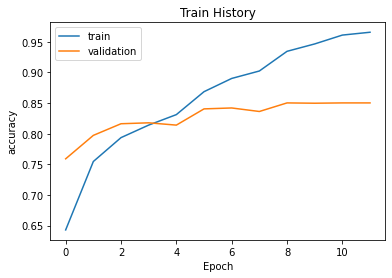

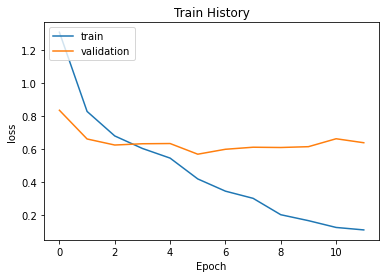

In [ ]:
# 顯示訓練結果
import matplotlib.pyplot as plt

def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()
    
show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [ ]:
model.evaluate(val_gen)

63/63 [==============================] - 48s 759ms/step - loss: 0.5696 - accuracy: 0.8405


[0.5695526003837585, 0.840499997138977]

In [ ]:
# model = load_model("/content/drive/MyDrive/模型/bk/efficient_bestmodel_multiinput1.h5")

In [ ]:
prediction_prob = model.predict(val_gen)
pre = np.argmax(prediction_prob, axis=1)
pre

63/63 [==============================] - 50s 742ms/step


array([30, 31, 31, ...,  2, 17, 19])

In [ ]:
true = np.array([d[path.split('/')[-2]] for path in val_img_paths])
true

array([30, 31, 31, ...,  2, 17, 19])

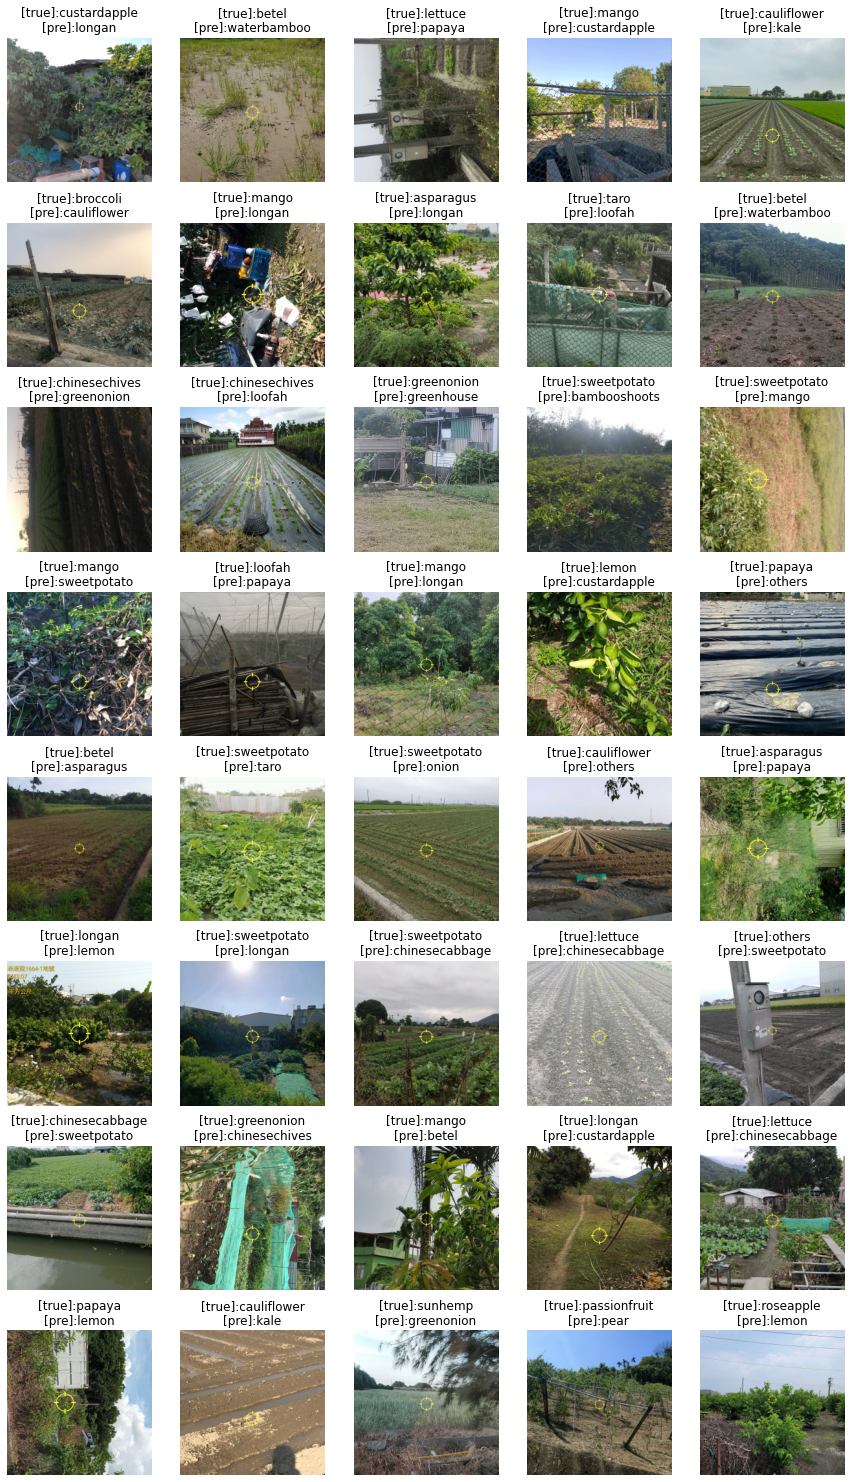

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
plt.figure(figsize=(15, 30))
idxs = np.nonzero(pre != true)[0]
idxs = idxs[:40]
# idxs = random.sample(set(idxs), 40)
width = 5
height = len(idxs) // width + 1
for i, idx in enumerate(idxs):
    img_path = val_img_paths[idx]
    img = np.array(load_img(img_path, target_size=(224,224)))
    label, p = true[idx], pre[idx]
    title = "[true]:{}\n[pre]:{}".format(classes[label], classes[p])
    plt.subplot(height, width, i+1)
    plt.title(title)
    plt.axis("off")
    plt.imshow(img)

In [ ]:
from sklearn.metrics import precision_score, f1_score

precision_score = precision_score(true, pre, average='weighted')
f1_score = f1_score(true, pre, average=None)
print('precision_score:', precision_score)
pd.DataFrame(f1_score, index=classes, columns=['f1_score']).sort_values(by='f1_score', ascending=False)

precision_score: 0.8435099967004567


,f1_score
waterbamboo,0.969231
tea,0.968198
pennisetum,0.929577
pear,0.913706
redbeans,0.910569
sunhemp,0.910506
soybeans,0.904412
taro,0.896552
greenhouse,0.890110
grape,0.887160


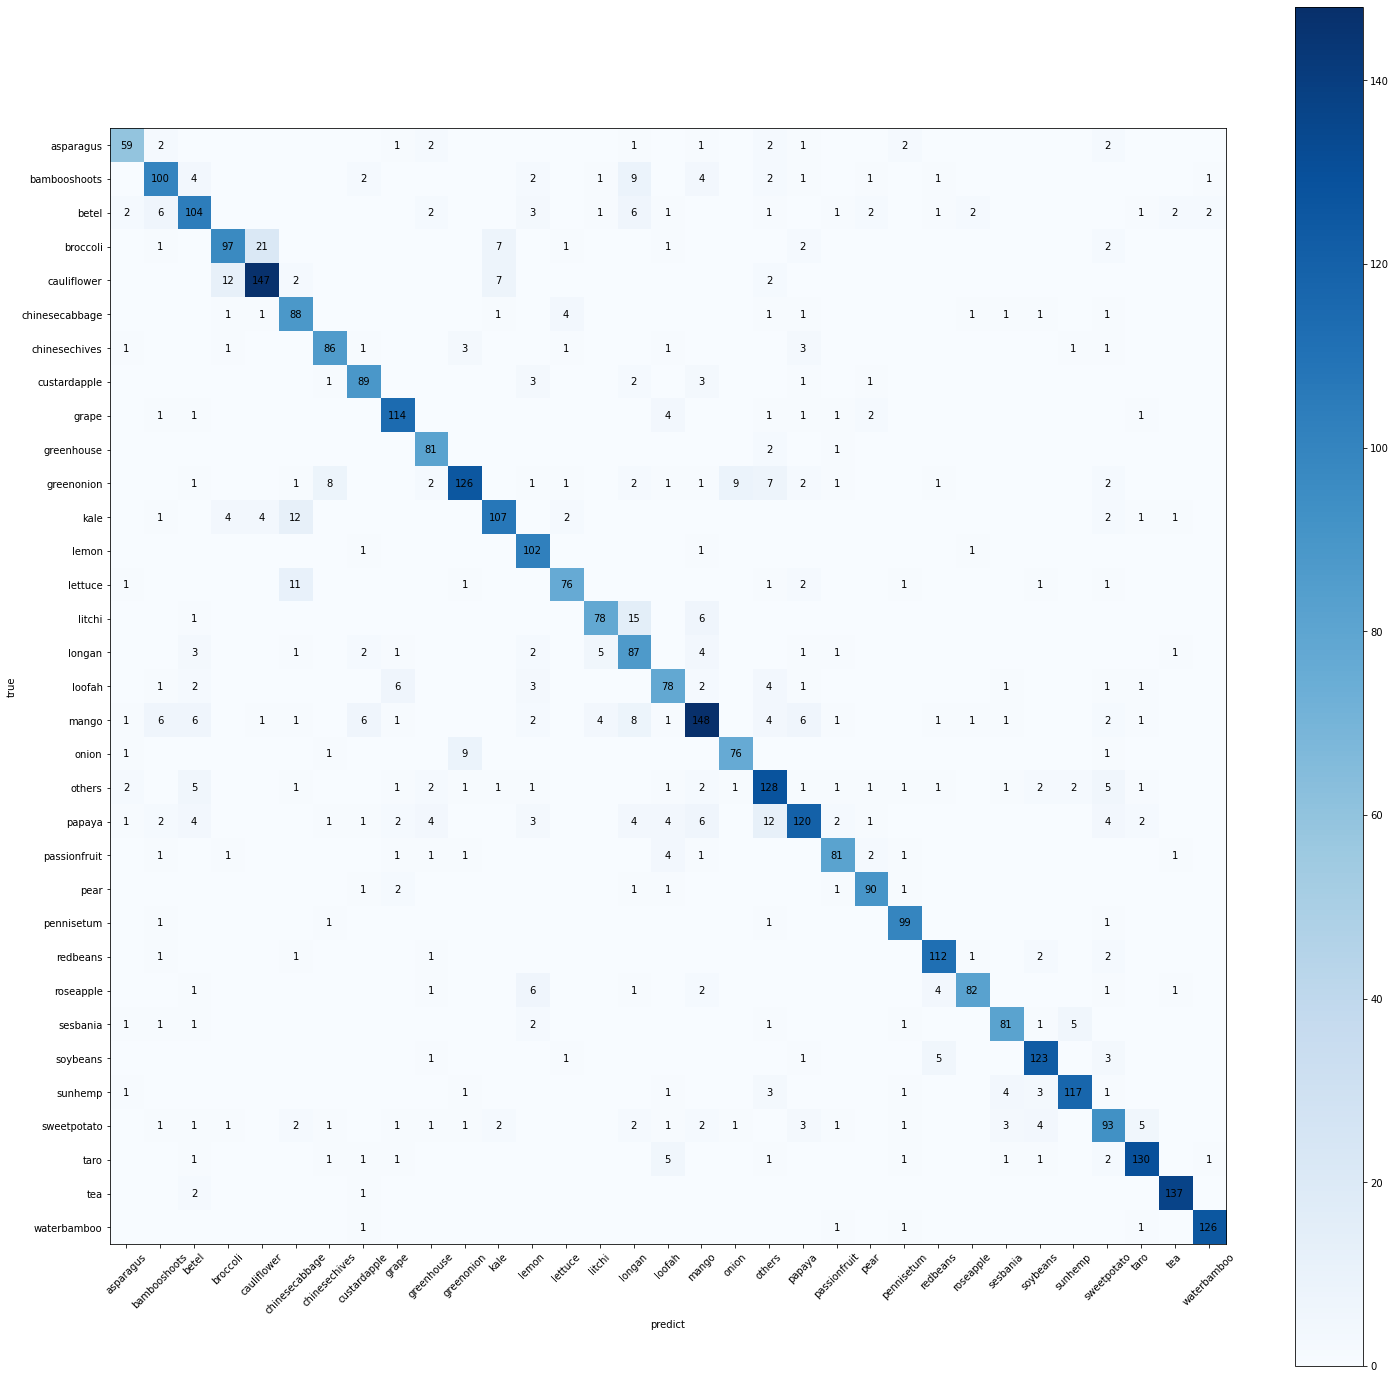

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, pre)
plt.figure(figsize=(25,25))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('predict')
plt.ylabel('true')
plt.xticks(range(len(cm)), classes, rotation=45)
plt.yticks(range(len(cm)), classes)

for i in range(len(cm)):
    for j in range(len(cm)):
        if cm[i][j] > 0:
            plt.text(x=j, y=i, s=cm[i][j], va='center', ha='center')

In [ ]:
prediction_prob = model.predict(predict_gen)
pre = np.argmax(prediction_prob, axis=1)
pre

175/175 [==============================] - 43s 226ms/step


array([ 2, 15, 23, ...,  2, 25, 24])

In [ ]:
files = [path.split('/')[-1] for path in predict_img_paths]
labels = [classes[idx] for idx in pre]
result = pd.DataFrame(
    {'filename': files,
     'label': labels
    }
)

result

,filename,label
0,2c14e018-e993-4bc9-bd4b-c2cecf703347.jpg,betel
1,2501979a-121e-460d-a48f-e952ddc210b6.jpg,longan
2,217fe4d6-30f1-48f3-a0b3-325b07e07d4d.jpg,pennisetum
3,26b657bd-f818-488e-9cfb-528af4f3676a.jpg,greenonion
4,2dd375a6-9040-47e7-a9aa-0851436ddb08.jpg,taro
...,...,...
11143,32f41c76-933e-4079-92a6-ca86231c3860.jpg,mango
11144,3a2ade5e-6141-424d-a34e-904672f8ddbe.jpg,asparagus
11145,3656a373-716f-42d6-9ce2-5de80df8faff.jpg,betel
11146,307d2004-5915-461b-9d84-7ba224d8e10a.jpg,roseapple


In [ ]:
result.to_csv('submit,csv', encoding="utf-8", index=False)